# Employee Retention

## Goal

Employee turnover is a very costly problem for companies. The cost of replacing an employee if often larger than 100K USD, taking into account the time spent to interview and find a replacement, placement fees, sign-on bonuses and the loss of productivity for several months.
__TURN INTO DOLLARS SAVED__

In this challenge, you have a data set with info about the employees and have to predict when employees are going to quit by understanding the main drivers of employee churn. __FEATURE IMPORTANCE MATTERS__


## Challenge Description
- The goal is to predict employee retention and understand its main drivers


## Hints:
What are the main factors that drive employee churn? Do they make sense? Explain your findings.

What might you be able to do for the company to address employee Churn, what would be follow-up actions?

If you could add to this data set just one variable that could help explain employee churn, what would that be?

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
%matplotlib inline

In [2]:
raw = pd.read_csv('employee_retention.csv')
raw = raw.drop(['Unnamed: 0'], axis=1)
raw.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,1001444.0,8,temp_contractor,0,5850.0,2008-01-26,2008-04-25
1,388804.0,8,design,21,191000.0,05.17.2011,2012-03-16
2,407990.0,3,design,9,90000.0,2012-03-26,2015-04-10
3,120657.0,2,engineer,20,298000.0,2013-04-08,2015-01-30
4,1006393.0,1,temp_contractor,0,8509.0,2008-07-20,2008-10-18


In [3]:
data = raw.copy()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34702 entries, 0 to 34701
Data columns (total 7 columns):
employee_id    34702 non-null float64
company_id     34702 non-null int64
dept           34702 non-null object
seniority      34702 non-null int64
salary         34463 non-null float64
join_date      34702 non-null object
quit_date      23510 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 1.9+ MB


In [4]:
# Create column for whether the individual is still working (i.e., 0, 1). We'll use this for classification later on. 
from datetime import timedelta
data['working'] = np.where(data.quit_date.isna(), 1, 0)

In [5]:
# Convert errors in datetime entry objects to datetime data types
data['quit_date'] = data.fillna('2015-12-13')
date_cols = ['join_date', 'quit_date']
for i in date_cols:
    data[i] = pd.to_datetime(data[i])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34702 entries, 0 to 34701
Data columns (total 8 columns):
employee_id    34702 non-null float64
company_id     34702 non-null int64
dept           34702 non-null object
seniority      34702 non-null int64
salary         34463 non-null float64
join_date      34702 non-null datetime64[ns]
quit_date      34702 non-null datetime64[ns]
working        34702 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(3), object(1)
memory usage: 2.1+ MB


In [6]:
# Create feature for time on the job (i.e., delta end-start)
data['duration_worked'] = (data['join_date'] - data['quit_date']).dt.days
data['join_date'] = [x.year for x in data['join_date']]
data['quit_date'] = [x.year for x in data['quit_date']]
data_cols = list(data)

In [7]:
# Check how unique vals and missing data for each feature. 
data = data.dropna()
for i in data_cols:
    print("Missing:", data[i].isna().sum(), "\n", data[i].value_counts(), "\n")

Missing: 0 
 330596.0     1
1003669.0    1
1003655.0    1
370756.0     1
1003657.0    1
            ..
825374.0     1
173576.0     1
628769.0     1
478226.0     1
512.0        1
Name: employee_id, Length: 34463, dtype: int64 

Missing: 0 
 1     9423
2     5178
3     3748
4     3046
5     2734
6     2243
7     2170
8     2011
9     1998
10    1873
12      23
11      16
Name: company_id, dtype: int64 

Missing: 0 
 temp_contractor     10000
customer_service     9089
engineer             4569
data_science         3157
sales                3148
marketing            3133
design               1367
Name: dept, dtype: int64 

Missing: 0 
 0     10000
8       996
12      978
6       939
9       933
2       931
16      931
5       925
10      920
11      919
7       917
14      912
15      903
19      902
4       886
13      886
17      881
3       868
18      861
1       858
20      838
23      782
21      770
22      758
24      737
25      708
26      683
27      634
29      625
28      580


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a153caa50>,
      dtype=object)

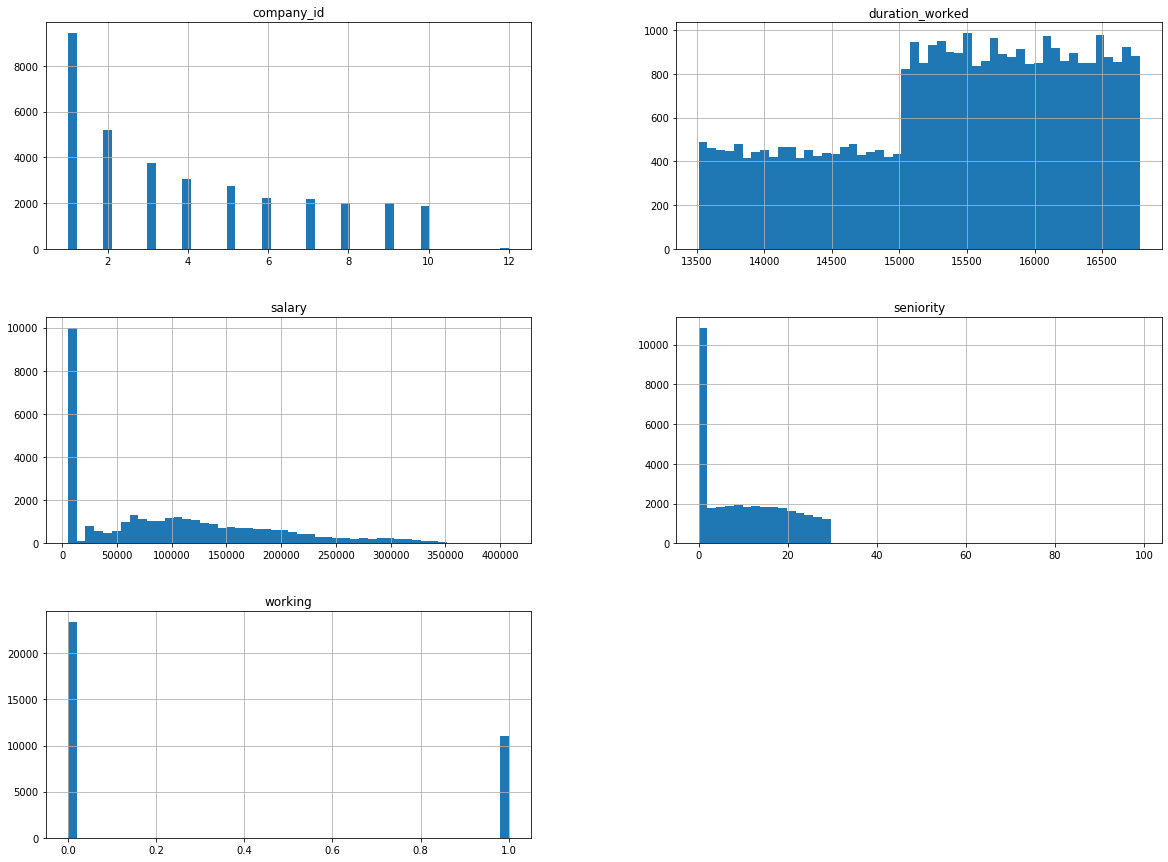

In [8]:
# Plot histogram of the different variables to see how things are shaking out. 
plot_cols = ['company_id', 'duration_worked', 'salary', 'seniority', 'working']
data[plot_cols].hist(bins=50, figsize=(20,15))

In [9]:
# It looks like the temp_contractor positions are making our data funky. 
# Let's remove them as they're irrelevant to the question at hand. 
data = data[data.dept != 'temp_contractor']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a15406290>,
      dtype=object)

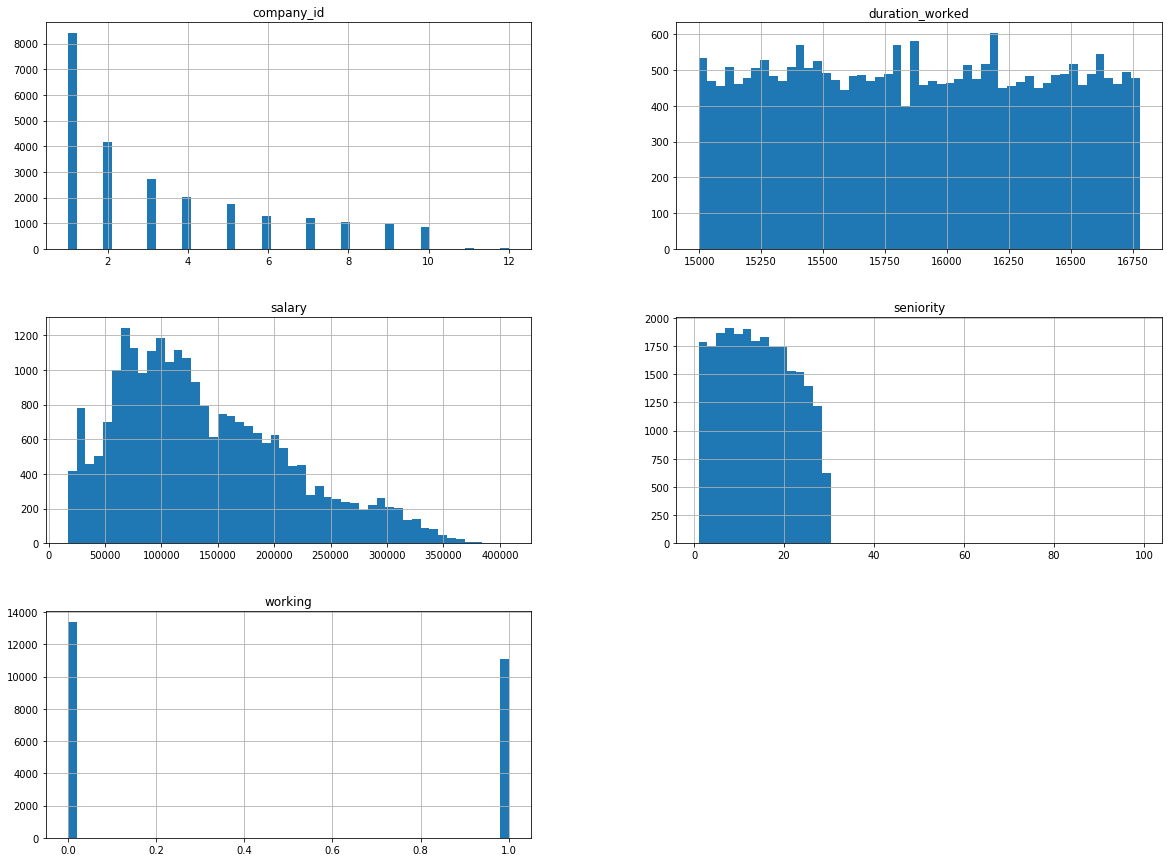

In [10]:
# Plot histogram of the different variables to see how things are shaking out. 
plot_cols = ['company_id', 'duration_worked', 'salary', 'seniority', 'working']
data[plot_cols].hist(bins=50, figsize=(20,15))

### It looks like: 
- The number of people from different companies is a bit unequal. Keep that tucked in our back pocket for later. __Opportunity for model improvement__
- Duration worked looks like two uniform distributions. These can be reclassified into ordinal or leave as continuous. __Opportunity for model improvement__
- Lots of people were hired with 0 experience and made little money in the year on the job. 
- Whether they're still working looks ~ 2:1 distribution. Not bad. But might be getting imbalanced. __Opportunity for model improvement__

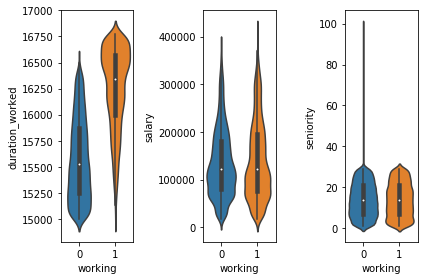

In [11]:
# Plot the relationship between each feature as a function of still working or not. 
import seaborn as sns
vio_cols = ['duration_worked', 'salary', 'seniority']
def vio_plot(df):
    f, axes = plt.subplots(1, 3)
    sns.violinplot(x='working', y='duration_worked', data=df, ax=axes[0])
    sns.violinplot(x='working', y='salary', data=df, ax=axes[1])
    sns.violinplot(x='working', y='seniority', data=df, ax=axes[2])
    plt.subplots_adjust(left=0.25, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.5)
    plt.tight_layout()
vio_plot(data)

### It looks like there's a solid difference here. These features should be helpful for a first pass!

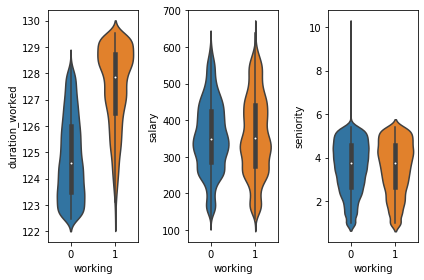

In [12]:
# These variables also seem a bit skewed. Let's see what different transformations do. 
# Square root transform
sqrt_test = data.copy()
for i in vio_cols:
    sqrt_test[i] = sqrt_test[i].transform(np.sqrt)
vio_plot(sqrt_test)

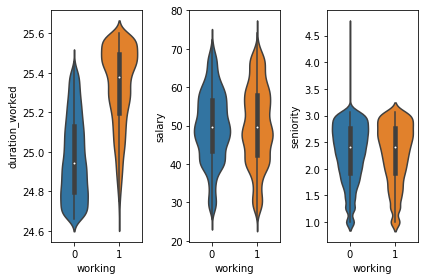

In [13]:
# Cube root transform
cube_root = data.copy()
for i in vio_cols:
    cube_root[i] = cube_root[i].transform(np.cbrt)
vio_plot(cube_root)

### Transforming doesn't seem to do too much. Left as since we'll be scaling down the line, anyway. 

# Baseline models. 
## Goal is to identify factors influencing churn. Two options for predictions:
1. Time to when they quit (i.e., duration worked at company is outcome variable - continuous). 
1. Are they still working at the company (i.e., classification task - binary).

## Let's create the feature and outcome dfs.

In [15]:
features = data.drop(['quit_date', 'working', 'duration_worked', 'join_date', 'employee_id'], axis=1)
outcomes = data[['quit_date', 'working', 'duration_worked', 'join_date', 'employee_id']]

In [17]:
# Recode necessary features via one-hot encoding
cols_recode = ['company_id', 'dept']
features = pd.get_dummies(features, columns = cols_recode)
features.shape # Check out the new shape

(24463, 20)

In [32]:
# Feature scaling 
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
scalar.fit(features)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [33]:
# Some packages
import matplotlib
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Some functions we'll use. 
def lin_metrics(x, y):
    ''' Prints four common metrics for evaluating regression predictions. '''
    print('Mean Absolute Error:', round(metrics.mean_absolute_error(x, y), 4))
    print('Mean Squared Error:', round(metrics.mean_squared_error(x, y), 4))
    print('Root Mean Squared Error:', round(np.sqrt(metrics.mean_squared_error(x, y)), 4))
    print('R^2 Math:,', round(metrics.r2_score(y_test, y_pred), 4))

def plot_scatter(x, y, xmin=None, xmax=None, ymin=None, ymax=None):
    '''Plots simple scatter plot of two datasets. We'll use to plot scatter of residuals.'''
    plt.scatter(x, y, cmap='viridis', alpha=0.1)
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel('Predicted', fontsize=20)
    plt.ylabel('Observed', fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    return plt.show()

def plot_residuals(x, y):
    '''Plot historgram of residuals.'''
    residuals = x - y
    plt.hist(residuals, bins=50, color='black')
    plt.xlabel('Residual')
    plt.ylabel('Num Observations')
    plt.show()

def bin_metrics(x, y):
    '''Prints four common metrics for evaluating classification predictions.'''
    print('Accuracy:', round(metrics.accuracy_score(x, y), 4))
    print('Precision:', round(metrics.precision_score(x, y), 4))
    print('Recall:', round(metrics.recall_score(x, y), 4))
    print('ROC_AUC:,', round(metrics.roc_auc_score(x, y), 4))
    print('F1:', round(metrics.f1_score(x, y), 4))

def plot_cm(x, y):
    cm = confusion_matrix(x, y)
    df_cm = pd.DataFrame(cm, columns=np.unique(x), index = np.unique(x))
    df_cm.index.name = 'Actual'
    df_cm.columns.name = 'Predicted'
    sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 20}, fmt='g')# font size
    plt.ylim([0, 2])

def return_coef(model, feature_names):
    feats_list = model.coef_
    rounded = [round(x, 3) for x in feats_list] # Round coefficients
    feats_coef = list(zip(feature_names, rounded)) # Zip the feature names to the respective coefficients
    res = sorted(feats_coef, key = lambda x: x[1]) # Sort the list by the coefficient vals (lowest-to-highest)
    return print("\nModel Coeff:\n", res)

## Let's start with the models for the continuous outcome variables. Options include:
1. Linear regression (simple, straightforward, good place to start). 
1. Lasso regression (see if we can reduce the feature space while maintaining accuracy). 
1. ElasticNet ((see if we can reduce the feature space while maintaining accuracy). 

Mean Absolute Error: 445.1379
Mean Squared Error: 264640.3761
Root Mean Squared Error: 514.4321
R^2 Math:, -0.0012

Model Coeff:
 [('company_id_11', -117.907), ('company_id_12', -64.171), ('dept_data_science', -12.964), ('dept_engineer', -7.462), ('dept_design', -6.818), ('seniority', -0.691), ('salary', 0.0), ('dept_sales', 2.478), ('company_id_5', 5.657), ('company_id_7', 9.281), ('dept_marketing', 11.626), ('company_id_1', 11.636), ('dept_customer_service', 13.14), ('company_id_10', 14.587), ('company_id_4', 18.731), ('company_id_8', 19.514), ('company_id_9', 20.667), ('company_id_6', 23.925), ('company_id_2', 24.182), ('company_id_3', 33.898)]


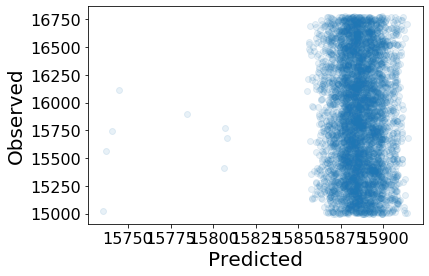

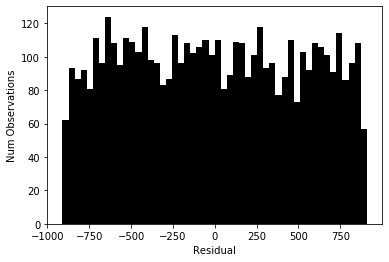

In [34]:
from sklearn.linear_model import LinearRegression
X_train, X_test, y_train, y_test = train_test_split(features, outcomes['duration_worked'], test_size=0.20, random_state = 333)
regressor = LinearRegression()
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
lin_metrics(y_test, y_pred)
return_coef(model=regressor, feature_names=features)
plot_scatter(y_pred, y_test)
plot_residuals(y_test, y_pred)

## The results above look really good. But maybe we can reduce some of those coefficients through L1 regularization. 

Max R^2: -0.00040612219929081483


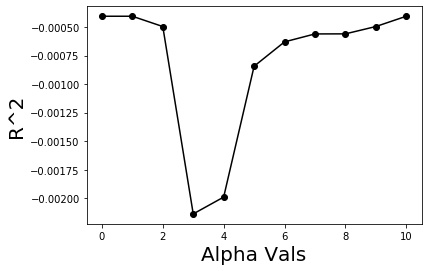

In [35]:
from sklearn.linear_model import Lasso
X_train, X_test, y_train, y_test = train_test_split(features, outcomes['duration_worked'], test_size=0.20, random_state = 649)
lasso_acc = []
pot_alphas = [1e100, 1e10, 1e5, 0.01, 0.1, 1, 10, 100, 1000, 100000, 10000000000]
for i in pot_alphas:
    model_lasso = Lasso(alpha=i)
    model_lasso.fit(X_train, y_train) 
    pred_train_lasso= model_lasso.predict(X_train)
    pred_test_lasso= model_lasso.predict(X_test)
    r_2 = metrics.r2_score(y_test, pred_test_lasso)
    lasso_acc.append(r_2)
plt.plot(lasso_acc, marker='o', color='black')
plt.ylabel('R^2', fontsize=20)
plt.xlabel('Alpha Vals', fontsize=20)
print("Max R^2:", max(lasso_acc))

In [36]:
# Looks like alphas ranging from 0.01 to 100 all do well. We'll go with 1. 
from sklearn.linear_model import Lasso
X_train, X_test, y_train, y_test = train_test_split(features, outcomes['duration_worked'], test_size=0.20, random_state = 649)
model_lasso = Lasso(alpha=1)
model_lasso.fit(X_train, y_train) 
y_pred = model_lasso.predict(X_test)
lin_metrics(y_test, y_pred)
return_coef(model=model_lasso, feature_names=features)

Mean Absolute Error: 446.5486
Mean Squared Error: 265352.8452
Root Mean Squared Error: 515.1241
R^2 Math:, -0.0008

Model Coeff:
 [('company_id_6', -3.205), ('seniority', -0.357), ('salary', -0.0), ('company_id_1', -0.0), ('company_id_2', 0.0), ('company_id_3', 0.0), ('company_id_4', -0.0), ('company_id_5', -0.0), ('company_id_7', -0.0), ('company_id_8', 0.0), ('company_id_9', 0.0), ('company_id_10', 0.0), ('company_id_11', -0.0), ('company_id_12', -0.0), ('dept_data_science', -0.0), ('dept_design', -0.0), ('dept_engineer', -0.0), ('dept_sales', 0.0), ('dept_marketing', 1.077), ('dept_customer_service', 2.101)]


# Classification models
1. Logistic regression
1. SVM
1. Random Forest
1. Linear SVC

## Logistic Classifier

Accuracy: 0.5438
Precision: 0.0
Recall: 0.0
ROC_AUC:, 0.5
F1: 0.0


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


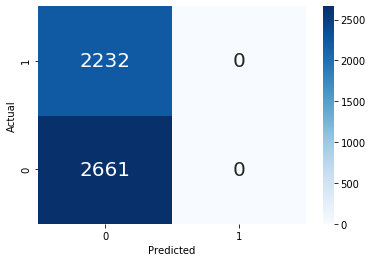

In [50]:
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(features,  outcomes['working'], test_size=0.20, random_state=649)
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
bin_metrics(y_test, y_pred)
plot_cm(y_test, y_pred)

## SVM

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Max Accuracy: 0.5438
Max F1: 0.6265


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


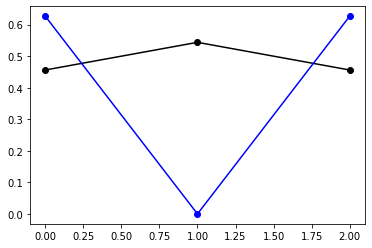

In [43]:
from sklearn import svm
X_train, X_test, y_train, y_test = train_test_split(features,  outcomes['working'], test_size=0.20, random_state = 649)
acc_scores = []
f1_scores = []
C_range = [0.01, 1, 100]
for i in C_range:
    classifier = svm.LinearSVC(C=i, max_iter=10000)
    classifier.fit(X_train, y_train)
    pred_train= classifier.predict(X_train)
    pred_test= classifier.predict(X_test)
    acc_val = metrics.accuracy_score(y_test, pred_test)
    acc_scores.append(acc_val)
    f1_val = metrics.f1_score(y_test, pred_test)
    f1_scores.append(f1_val)
plt.plot(acc_scores, marker='o', color='black')
plt.plot(f1_scores, marker='o', color='blue')
print("Max Accuracy:", round(max(acc_scores), 4))
print('Max F1:', round(max(f1_scores), 4))

Accuracy: 0.4562
Precision: 0.4562
Recall: 1.0
ROC_AUC:, 0.5
F1: 0.6265


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


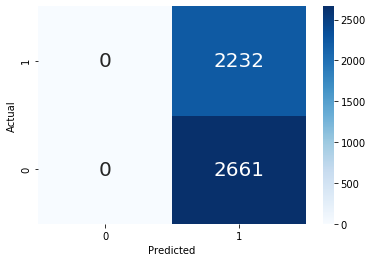

In [52]:
X_train, X_test, y_train, y_test = train_test_split(features,  outcomes['working'], test_size=0.20, random_state = 649)
classifier = svm.LinearSVC(C=100, max_iter=10000)
classifier.fit(X_train, y_train)
pred_train= classifier.predict(X_train)
pred_test= classifier.predict(X_test)
bin_metrics(y_test, pred_test)
plot_cm(y_test, pred_test)

### SVM with rbf kernel 

Max Accuracy: 0.54
Max F1: 0.4


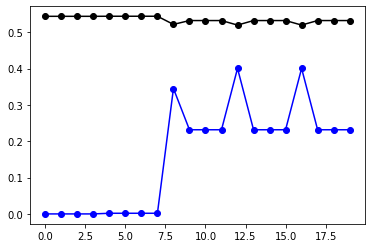

In [53]:
X_train, X_test, y_train, y_test = train_test_split(features,  outcomes['working'], test_size=0.20, random_state = 649)
acc_scores = []
f1_scores = []
C_range = [0.01, 0.1, 1, 10, 100]
gamma_range = [1, 10, 100, 1000]
for i in C_range:
    for k in gamma_range:
        classifier = svm.SVC(kernel = 'rbf', C=i, gamma=k)
        classifier.fit(X_train, y_train)
        pred_train= classifier.predict(X_train)
        pred_test= classifier.predict(X_test)
        acc_val = metrics.accuracy_score(y_test, pred_test)
        acc_scores.append(acc_val)
        f1_val = f1_score(y_test, pred_test)
        f1_scores.append(f1_val)
plt.plot(acc_scores, marker='o', color='black')
plt.plot(f1_scores, marker='o', color='blue')
print("Max Accuracy:", round(max(acc_scores), 2))
print('Max F1:', round(max(f1_scores), 2))

## Random Forest

Max Accuracy: 0.5555
Max F1: 0.4621


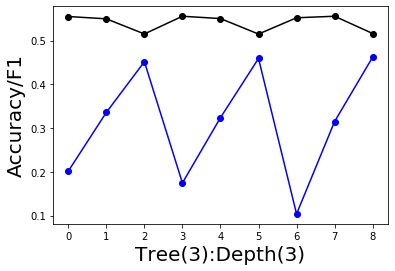

In [54]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(features,  outcomes['working'], test_size=0.20, random_state = 649)
acc_scores = []
f1_scores = []
nEst_range = [10, 50, 500]
depth_range = [2, 10, 100]
for i in nEst_range:
    for k in depth_range:
        classifier = RandomForestClassifier(n_estimators=i, max_depth=k)
        classifier.fit(X_train, y_train)
        pred_train= classifier.predict(X_train)
        pred_test= classifier.predict(X_test)
        acc_val = metrics.accuracy_score(y_test, pred_test)
        acc_scores.append(acc_val)
        f1_val = f1_score(y_test, pred_test)
        f1_scores.append(f1_val)
plt.plot(acc_scores, marker='o', color='black')
plt.plot(f1_scores, marker='o', color='blue')
plt.ylabel('Accuracy/F1', fontsize=20)
plt.xlabel('Tree(3):Depth(3)', fontsize=20)
print("Max Accuracy:", round(max(acc_scores), 4))
print('Max F1:', round(max(f1_scores), 4))

Accuracy: 0.5232
Precision: 0.4757
Recall: 0.4435
ROC_AUC:, 0.5168
F1: 0.4591


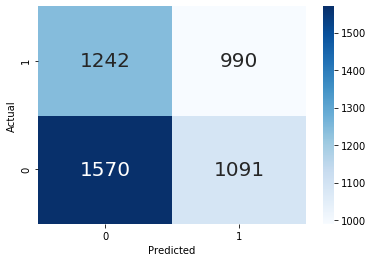

In [55]:
# Create final model to get feature importance
X_train, X_test, y_train, y_test = train_test_split(features,  outcomes['working'], test_size=0.20, random_state = 649)
classifier = RandomForestClassifier(n_estimators=10, max_depth=100)
classifier.fit(X_train, y_train)
pred_train= classifier.predict(X_train)
pred_test= classifier.predict(X_test)
acc_val = metrics.accuracy_score(y_test, pred_test)
f1_val = f1_score(y_test, pred_test)
bin_metrics(y_test, pred_test)
plot_cm(y_test, pred_test)

In [56]:
feature_importances = pd.DataFrame(classifier.feature_importances_, index = X_train.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances.head(10))

                importance
salary            0.682478
seniority         0.251572
company_id_1      0.005660
company_id_3      0.005342
company_id_5      0.005210
company_id_6      0.005110
company_id_7      0.004562
company_id_8      0.004314
company_id_2      0.004260
dept_marketing    0.004011


### Nearest Neighbor

Max Accuracy: 0.54
Max F1: 0.46


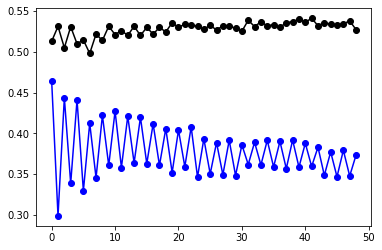

In [57]:
from sklearn.neighbors import KNeighborsClassifier
X_train, X_test, y_train, y_test = train_test_split(features,  outcomes['working'], test_size=0.20, random_state = 649)
acc_scores = []
f1_scores = []
neigh_range = list(range(1, 50))
for i in neigh_range:
    classifier = KNeighborsClassifier(n_neighbors=i)
    classifier.fit(X_train, y_train)
    pred_train= classifier.predict(X_train)
    pred_test= classifier.predict(X_test)
    acc_val = metrics.accuracy_score(y_test, pred_test)
    acc_scores.append(acc_val)
    f1_val = f1_score(y_test, pred_test)
    f1_scores.append(f1_val)
plt.plot(acc_scores, marker='o', color='black')
plt.plot(f1_scores, marker='o', color='blue')
print("Max Accuracy:", round(max(acc_scores), 2))
print('Max F1:', round(max(f1_scores), 2))

# Checklist
1. Frame the problem and look at the big picture.
1. Get the data.
1. Explore the data to gain insights.
1. Prepare the data to better expose the underlying data patterns to Machine Learning algorithms.
1. Explore many different models and shortlist the best ones.
1. Fine-tune your models and combine them into a great solution.
1. Present your solution.
1. Launch, monitor, and maintain your system.

## Frame the problem. 
1. Define the objective in business terms.
1. How will your solution be used?
1. What are the current solutions/workarounds (if any)?
1. How should you frame this problem (supervised/unsupervised, online/offline, etc.)?
1. How should performance be measured?
1. Is the performance measure aligned with the business objective?
1. What would be the minimum performance needed to reach the business objective?
1. What are comparable problems? Can you reuse experience or tools?
1. Is human expertise available?
1. How would you solve the problem manually?
1. List the assumptions you (or others) have made so far.
1. Verify assumptions if possible.

## Get the Data
1. Problems with data stewardship?
1. List the data you need and how much you need.
1. Find and document where you can get that data.
1. Check how much space it will take.
1. Check legal obligations, and get authorization if necessary.
1. Get access authorizations.
1. Create a workspace (with enough storage space).
1. Get the data.
1. Convert the data to a format you can easily manipulate (without changing the data itself).
1. Ensure sensitive information is deleted or protected (e.g., anonymized).
1. Check the size and type of data (time series, sample, geographical, etc.).
1. Sample a test set, put it aside, and never look at it (no data snooping!).

## Explore the Data
1. Create a copy of the data for exploration (sampling it down to a manageable size if necessary).
1. Create a Jupyter notebook to keep a record of your data exploration.
1. Study each attribute and its characteristics:
    1. Name
    1. Type (categorical, int/float, bounded/unbounded, text, structured, etc.)
    1. % of missing values
    1. Noisiness and type of noise (stochastic, outliers, rounding errors, etc.)
    1. Usefulness for the task
    1. Type of distribution (Gaussian, uniform, logarithmic, etc.)
1. For supervised learning tasks, identify the target attribute(s).
1. Visualize the data.
1. Study the correlations between attributes.
1. Study how you would solve the problem manually.
1. Identify the promising transformations you may want to apply.
1. Identify extra data that would be useful (go back to “Get the Data” ).
1. Document what you have learned.

## Prepare the Data
1. Work on copies of the data (keep the original dataset intact).
1. Write functions for all data transformations you apply, for five reasons:
1. So you can easily prepare the data the next time you get a fresh dataset
1. So you can apply these transformations in future projects
1. To clean and prepare the test set
1. To clean and prepare new data instances once your solution is live
1. To make it easy to treat your preparation choices as hyperparameters
1. Data cleaning:
    1. Fix or remove outliers (optional).
    1. Fill in missing values (e.g., with zero, mean, median…) or drop their rows (or columns).
1. Feature selection (optional):
    1. Drop the attributes that provide no useful information for the task.
1. Feature engineering, where appropriate:
    1. Discretize continuous features.
    1. Decompose features (e.g., categorical, date/time, etc.).
    1. Add promising transformations of features (e.g., log( x ), sqrt( x ), x 2 , etc.).
    1. Aggregate features into promising new features.
1. Feature scaling:
    1. Standardize or normalize features.

## Shortlist Promising Models
1. If the data is huge, you may want to sample smaller training sets so you can train many different models in a reasonable time (be aware that this penalizes complex models such as large neural nets or Random Forests).
1. Once again, try to automate these steps as much as possible.
1. Train many quick-and-dirty models from different categories (e.g., linear, naive Bayes, SVM, Random Forest, neural net, etc.) using standard parameters.
1. Measure and compare their performance.
    1. For each model, use N fold cross-validation and compute the mean and standard deviation of the performance measure on the N folds.
1. Analyze the most significant variables for each algorithm.
1. Analyze the types of errors the models make.
    1. What data would a human have used to avoid these errors?
1. Perform a quick round of feature selection and engineering.
1. Perform one or two more quick iterations of the five previous steps.
1. Shortlist the top three to five most promising models, preferring models that make different types of errors.

## Fine-Tune the System
1. You will want to use as much data as possible for this step, especially as you move toward the end of fine-tuning.
1. As always, automate what you can.
1. Fine-tune the hyperparameters using cross-validation:
    1. Treat your data transformation choices as hyperparameters, especially when you are not sure about them (e.g., if you’re not sure whether to replace missing values with zeros or with the median value, or to just drop the rows).
    1. Unless there are very few hyperparameter values to explore, prefer random search over grid search. If training is very long, you may prefer a Bayesian optimization approach (e.g., using Gaussian process priors, as described by Jasper Snoek et al.).
1. Try Ensemble methods. Combining your best models will often produce better performance than running them individually.
1. Once you are confident about your final model, measure its performance on the test set to estimate the generalization error.

## Present Your Solution
1. Document what you have done.
1. Create a nice presentation.
1. Make sure you highlight the big picture first.
1. Explain why your solution achieves the business objective.
1. Don’t forget to present interesting points you noticed along the way.
1. Describe what worked and what did not.
1. List your assumptions and your system’s limitations.
1. Ensure your key findings are communicated through beautiful visualizations or easy-to-remember statements (e.g., “the median income is the number-one predictor of housing prices”).

## Launch!
1. Get your solution ready for production (plug into production data inputs, write unit tests, etc.).
1. Write monitoring code to check your system’s live performance at regular intervals and trigger alerts when it drops.
    1. Beware of slow degradation: models tend to “rot” as data evolves.
    1. Measuring performance may require a human pipeline (e.g., via a crowdsourcing service).
    1. Also monitor your inputs’ quality (e.g., a malfunctioning sensor sending random values, or another team’s output becoming stale). This is particularly important for online learning systems.
1. Retrain your models on a regular basis on fresh data (automate as much as possible ).